In [1]:
import numpy as np
import pandas as pd
import torch
from transformers import BertForSequenceClassification, BertTokenizer
import os
from collections import Counter


c:\Users\jiyon\Documents\GitHub\LLM-reviewtransformation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Load fine tuned Bert model

In [33]:
model_path = "../../SenWave-BERT/SenWave-BERT"
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model = BertForSequenceClassification.from_pretrained(model_path)
model.eval()  

c:\Users\jiyon\Documents\GitHub\LLM-reviewtransformation\.venv\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\jiyon\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


OSError: Incorrect path_or_model_id: '../../SenWave-BERT/SenWave-BERT'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [ ]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.sigmoid(outputs.logits)
            
        predicted_labels = (probs > 0.5).int()  # multilabel predictions
        
        predicted_labels_list = []
        for i, val in enumerate(predicted_labels[0]):
            if val == 1:
                label = model.config.id2label[i]
                predicted_labels_list.append(label)
        
        # if no labels are predicted (<.5) then just take argmax
        if not predicted_labels_list:
            predicted_label_idx = torch.argmax(probs, dim=-1).item()  
            label = model.config.id2label[predicted_label_idx]
            return [label]  
        
        return predicted_labels_list

# Labelling

In [ ]:
df = pd.read_csv("../../Dataset/tweets/transformed_final.csv", index_col=False)

In [ ]:
df

,tweets,cleaned,cleaned_transform,labels,batch,transformed_tweets_groq,groq_transformed,transformed_tweets_gemini,gemini_transformed,transformed_tweets_gpt,...,before_hatebert_pred,after_hatebert_pred_groq,after_hatebert_pred_gemini,after_hatebert_pred_gpt4o,after_hatebert_pred_deepseek,hate_keyword_before,hate_keyword_groq,hate_keyword_gemini,hate_keyword_gpt,hate_keyword_deepseek
0,b'If you bother to do the maths then in actual...,bother math actual fact socalled reformer isla...,if you bother to do the maths then in actual f...,Religion,1,"""If you take the time to do the math, you'll f...",1,A mathematical analysis reveals that those cla...,1,"""If you take the time to do the calculations, ...",...,1,1,1,1,1,0,0,0,0,0
1,"b'Muslims be like: The Quran is true, it says ...",muslim like quran true say quran,muslims be like the quran is true it says so i...,Religion,1,"""I'm fascinated by the Quran's teachings and t...",1,Some Muslims express their faith by citing the...,1,"""Some Muslims believe that the Quran is true b...",...,1,1,1,1,1,0,0,0,0,0
2,That painting by Jim Carrey of Sharia Huckabal...,painting jim carrey sharia huckabaloney spitti...,that painting by jim carrey of sharia huckabal...,Religion,1,"""I'm struck by Jim Carrey's depiction of Shari...",1,I find Jim Carrey's painting to be a striking ...,1,"""That painting by Jim Carrey captures a striki...",...,1,1,1,1,1,0,0,0,0,0
3,"b""So I say.. fck Islam it should be banned in ...",say fck islam banned uk go belief womens right,so i say fck islam it should be banned in the ...,Religion,1,"""I believe Islamic laws and beliefs often clas...",1,I believe that certain Islamic practices confl...,1,"""I believe there should be a discussion about ...",...,1,1,1,1,1,0,0,0,0,0
4,"b""Theresa May has her head so far up the Musla...",theresa may head far muslamic as doesnt need s...,theresa may has her head so far up the muslami...,Religion,1,"""Concerned about PM Theresa May's response to ...",1,I strongly disagree with Theresa May's policies.,1,"""Theresa May seems to have strong alignment wi...",...,1,1,1,1,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,b'Why does this Globalist Pope meddle in suppo...,globalist pope meddle supporting muslim invasi...,why does this globalist pope meddle in support...,Disciminatory,20,"""I'm concerned about the Pope's influence on g...",1,I question the Pope's focus on supporting Musl...,1,"""Why does this globalist Pope focus on support...",...,1,1,1,1,1,0,0,0,0,0
396,b'RT @BeckysTidePods: FLASHBACK: for the selec...,flashback selective memory whining hypocrite b...,flashback for the selective memory whining hyp...,Disciminatory,20,"""Remembering the contrast between past actions...",1,"Reflecting on past events, it's worth remember...",1,"""Flashback for those with selective memory: Th...",...,1,1,1,1,1,0,0,0,0,0
397,b'RT @chriscol22nd: Illinois: Two Muslims indi...,illinois two muslim indicted spying behalf ira...,illinois two muslims indicted for spying on be...,Disciminatory,20,"""Breaking: Two individuals in Illinois have be...",1,Two individuals in Illinois have been indicted...,1,"""Two individuals in Illinois have been indicte...",...,1,1,1,1,1,0,0,0,0,0
398,b'@najwazebian Wishing all young Lebanese fema...,wishing young lebanese female teacher living l...,wishing all young lebanese female teachers liv...,Disciminatory,20,"""Wishing all young Lebanese female teachers li...",1,Wishing all young Lebanese female teachers in ...,1,"""Wishing all young Lebanese female teachers li...",...,1,1,1,1,1,0,0,0,0,0


In [34]:
df.columns

NameError: name 'df' is not defined

In [66]:
columns = ['cleaned_transform', 'transformed_tweets_groq', 'transformed_tweets_gemini', 'transformed_tweets_gpt', 'transformed_tweets_deepseek']
summary = {}
for col in columns:
    all_labels = df[col].apply(lambda x: predict_sentiment(x))
    flat_labels = [label for labels in all_labels for label in labels]
    label_counts = Counter(flat_labels)
    summary[col] = label_counts

summary_df = pd.DataFrame(summary).fillna(0).astype(int).T 
summary_df.index.name = "Model"

In [67]:
summary_df

,Annoyed,Joking,Optimistic,Official report,Anxious,Sad,Denial,Thankful
Model,,,,,,,,
cleaned_transform,259,165,33,30,9,10,6,0
transformed_tweets_groq,145,55,190,36,5,8,5,1
transformed_tweets_gemini,163,59,118,73,15,18,6,1
transformed_tweets_gpt,163,72,111,65,5,15,10,1
transformed_tweets_deepseek,164,58,133,54,6,13,15,0


In [ ]:
summary_df.to_csv("../../Dataset/tweets/sentiment.csv")

# Visualizations

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
# set sns plot 
sns.set_theme()
sns.set_theme(style="whitegrid")
sns.set_context("talk")

In [28]:
sentiment = pd.read_csv("../../Dataset/tweets/sentiment.csv")

In [29]:
sentiment

,Annoyed,Joking,Optimistic,Official report,Anxious,Sad,Denial,Thankful
0,259,165,33,30,9,10,6,0
1,145,55,190,36,5,8,5,1
2,163,59,118,73,15,18,6,1
3,163,72,111,65,5,15,10,1
4,164,58,133,54,6,13,15,0


In [30]:
sentiment = sentiment.reset_index().rename(columns={"index": "Observation"})

In [31]:
sentiment

,Observation,Annoyed,Joking,Optimistic,Official report,Anxious,Sad,Denial,Thankful
0,0,259,165,33,30,9,10,6,0
1,1,145,55,190,36,5,8,5,1
2,2,163,59,118,73,15,18,6,1
3,3,163,72,111,65,5,15,10,1
4,4,164,58,133,54,6,13,15,0


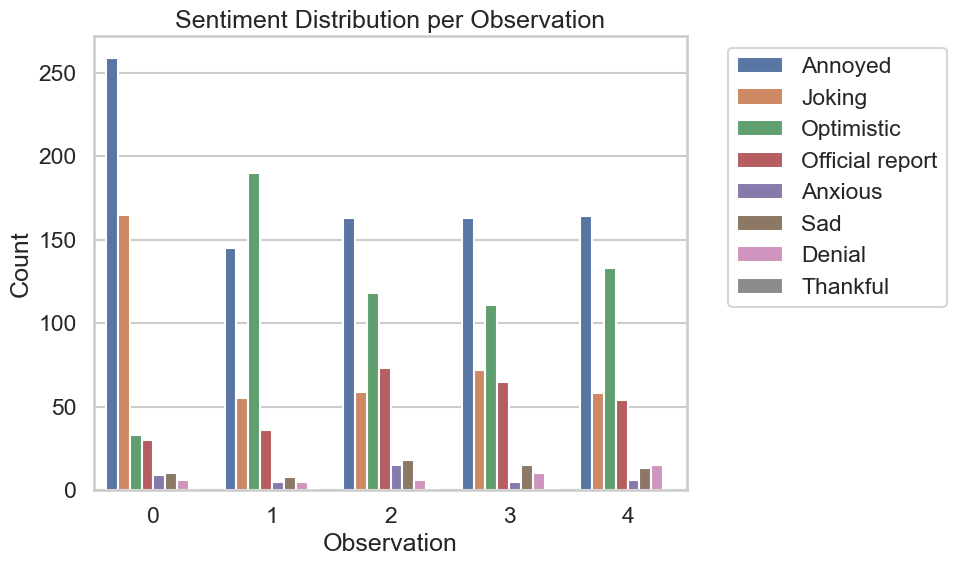

In [32]:
s_melted = sentiment.melt(id_vars='Observation', var_name='Sentiment', value_name='Count')
plt.figure(figsize=(10,6))
sns.barplot(data=s_melted, x='Observation', y='Count', hue='Sentiment')
plt.title('Sentiment Distribution per Observation')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

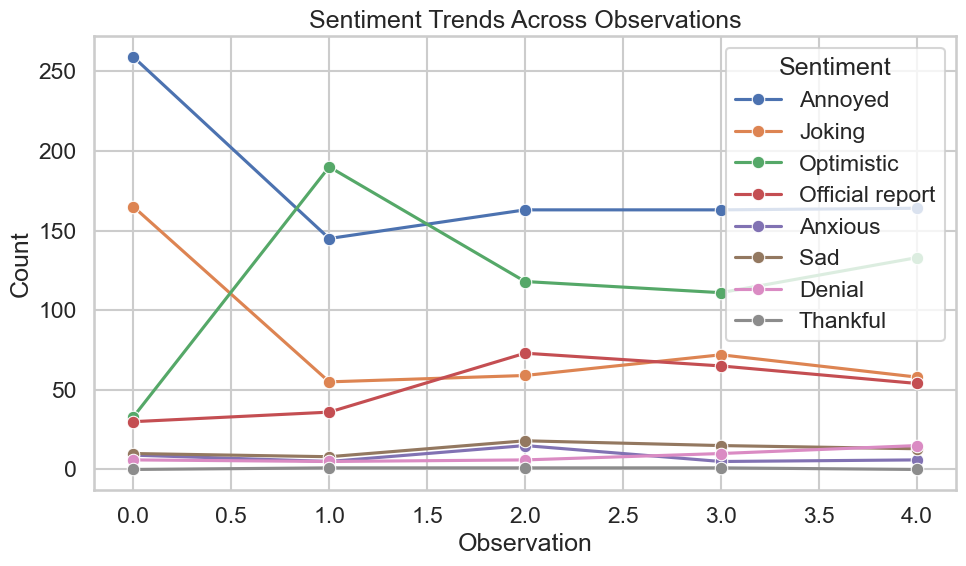

In [36]:
plt.figure(figsize=(10,6))
sns.lineplot(data=s_melted, x='Observation', y='Count', hue='Sentiment', marker='o')
plt.title('Sentiment Trends Across Observations')
plt.grid(True)
plt.tight_layout()
plt.show()

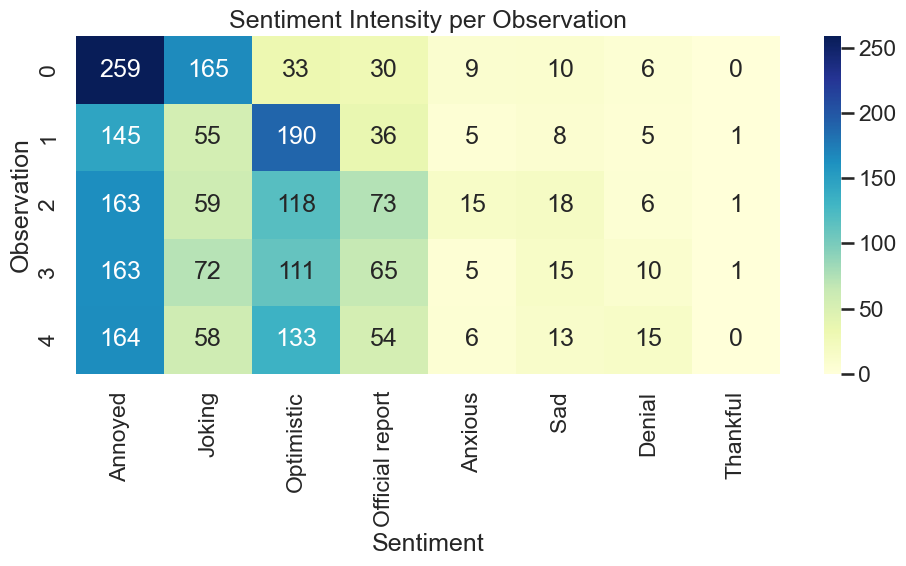

In [37]:
plt.figure(figsize=(10,6))
sns.heatmap(sentiment.drop(columns='Observation'), annot=True, fmt='d', cmap='YlGnBu')
plt.title('Sentiment Intensity per Observation')
plt.xlabel('Sentiment')
plt.ylabel('Observation')
plt.tight_layout()
plt.show()